### 1 加载数据集

shape of moons: (10000, 2)
data shape= (2, 10000)
[-0.07085869  0.09176848 -0.06025312 ...  0.09482823 -0.06974319
 -0.09169894] [ 0.0447147  -0.10437735  0.17489998 ... -0.07003038  0.01595138
  0.08536308]
torch.Size([10000, 2])


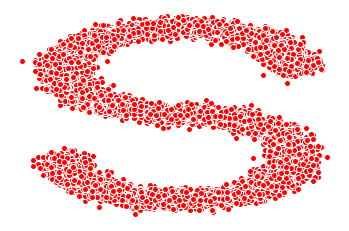

In [74]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

s_curve, _ = make_s_curve(10**4, noise=0.1) #s_curve是sklean中的一个数据集
s_curve = s_curve[:,[0,2]]/10.0
print("shape of moons:", np.shape(s_curve)) #(10000, 2)

data = s_curve.T
print('data shape=', data.shape) #(2, 10000)
print(*data)#在列表、元组、字典、集合、数组前面加上*，
#打印的输出结果可以看出，这些数据结构中元素都被分成一个一个的独立元素,这里会将data分成两个list。
fig, ax = plt.subplots()
ax.scatter(*data, color='red', edgecolor='white') #就是绘制了10000个散点,
ax.axis('off')

dataset = torch.Tensor(s_curve).float()
print(dataset.shape) #torch.Size([10000, 2])

### 2 确定超参数的值

In [75]:
num_steps = 100 #对于step，一开始由beta，分布的均值和标准差来共同确定。

#制定每一步的beta
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5 #最小值0.00001，最大值0.005 ，beta值逐步增大，就像学习率一样，是一个按照时间步变化的量
#并且betas值比较小，这样我们才有理由相信，每一个逆扩散过程也是一个高斯分布。
#计算alpha, alpha_prod, alpha_prod_previous, alpha_bar_sqrt等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0) #计算累积连乘
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0) #p表示previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1- alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape == \
alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape\
== one_minus_alphas_bar_sqrt.shape

print("all the same shape:", betas.shape) #torch.Size([100])与 num_steps个数相等。





all the same shape: torch.Size([100])


### 3 确定扩散过程任意时刻的采样值

In [76]:
#给定初始的训练数据分布，我们就能算出任意时刻的采样值，基于x_0和参数重整化技巧,采样出x_t的值
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0) #noise是从正态分布中生成的随机噪声
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    
    return (alphas_t * x_0 + alphas_1_m_t * noise) #在x_0的基础上添加噪声



### 4 演示原始数据分布加载100步后的效果

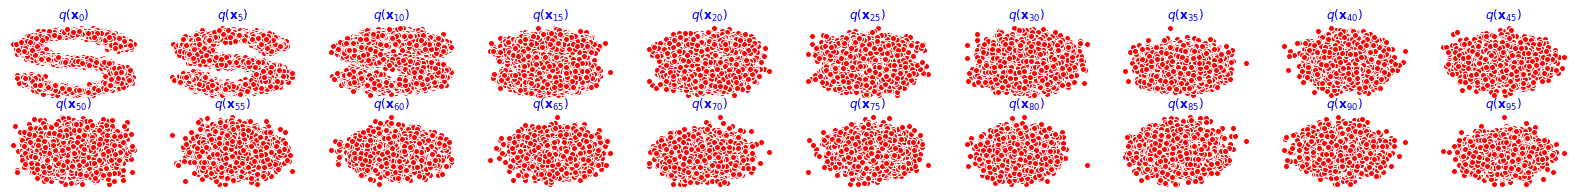

In [77]:
num_shows = 20
fig,axs = plt.subplots(2, 10, figsize=(28, 3))
plt.rc('text', color='blue')

#共有10000个点，每个点包含两个坐标，
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10 #行
    k = i%10 #列
    q_i = q_x(dataset, torch.tensor([i*num_steps//num_shows])) #生成t时刻的采样数据，num_steps//num_shows这个值为5
    axs[j,k].scatter(q_i[:,0], q_i[:,1], color='red', edgecolor='white') #把第0列和第1列拿出来绘制散点图
    
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows) + '})$')
    

### 5 编写逆扩散过程高斯分布的模型

In [119]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()
        
        self.linears = nn.ModuleList([
            nn.Linear(2, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units, num_units),
            nn.ReLU(),
            nn.Linear(num_units,2),
            
        ])
        
        self.step_embeddings = nn.ModuleList(
        [
            nn.Embedding(n_steps, num_units), #n_steps一百步
            nn.Embedding(n_steps, num_units),
            nn.Embedding(n_steps, num_units),
        ])
        
    def forward(self, x, t): #该网络输入维度和输出维度一致
        for idx, embedding_layer in enumerate(self.step_embeddings):
            #print(idx, embedding_layer)
            t_embedding = embedding_layer(t)
            #print('t_embedding.shape', t_embedding.shape)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        
        x = self.linears[-1](x)
        
        return x

### 6 编写训练误差函数

In [120]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    
    batch_size = x_0.shape[0]
    
    #对一个batch_size样本生成随机的时刻t，为了尽量让生成的t不要太重复。覆盖到更多不同的t
    t = torch.randint(0, n_steps, size=(batch_size//2,)) #先生成batch_size的一半
    t = torch.cat([t, n_steps-1-t], dim=0)#另外一半根据n_steps-1-t生成 [batch_size]
    t = t.unsqueeze(-1) #[batch_size，1]，增加一维，为了计算方便
    
    #x_0的系数
    a = alphas_bar_sqrt[t]
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪音epsilon
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x = x_0 * a + e * aml
    
    #print('t.shape=', t.shape) #torch.Size([128, 1])
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))
    
    #与随机噪声一起计算误差，求平均值
    return (e - output).square().mean()

### 7 编写逆扩散采样函数(inference过程)

In [121]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]一致到x[0]"""
    
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
        
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x, t)
    
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    
    z = torch.randn_like(x) #生成正态分布随机量
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)
    

### 8 模型训练

MLPDiffusion(
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
  (step_embeddings): ModuleList(
    (0): Embedding(100, 128)
    (1): Embedding(100, 128)
    (2): Embedding(100, 128)
  )
)
tensor(0.6575, grad_fn=<MeanBackward0>)
tensor(0.4841, grad_fn=<MeanBackward0>)
tensor(0.4072, grad_fn=<MeanBackward0>)
tensor(0.5326, grad_fn=<MeanBackward0>)
tensor(0.2687, grad_fn=<MeanBackward0>)
tensor(0.3813, grad_fn=<MeanBackward0>)
tensor(0.3348, grad_fn=<MeanBackward0>)
tensor(0.1968, grad_fn=<MeanBackward0>)
tensor(0.2609, grad_fn=<MeanBackward0>)
tensor(0.3609, grad_fn=<MeanBackward0>)
tensor(0.1483, grad_fn=<MeanBackward0>)
tensor(0.1970, grad_fn=<MeanBackward0>)
tensor(0.3602, grad_fn=<MeanBackward0>)
tensor(0.2624, grad

<ipython-input-122-1482d7a55ea9>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28,3))


tensor(0.2574, grad_fn=<MeanBackward0>)
tensor(0.2271, grad_fn=<MeanBackward0>)
tensor(0.4270, grad_fn=<MeanBackward0>)
tensor(0.2060, grad_fn=<MeanBackward0>)
tensor(0.5548, grad_fn=<MeanBackward0>)
tensor(0.2170, grad_fn=<MeanBackward0>)
tensor(0.3220, grad_fn=<MeanBackward0>)
tensor(0.4048, grad_fn=<MeanBackward0>)
tensor(0.2022, grad_fn=<MeanBackward0>)
tensor(0.3990, grad_fn=<MeanBackward0>)
tensor(0.3100, grad_fn=<MeanBackward0>)
tensor(0.4105, grad_fn=<MeanBackward0>)
tensor(0.2572, grad_fn=<MeanBackward0>)
tensor(0.5869, grad_fn=<MeanBackward0>)
tensor(0.2296, grad_fn=<MeanBackward0>)
tensor(0.4551, grad_fn=<MeanBackward0>)
tensor(0.3381, grad_fn=<MeanBackward0>)
tensor(0.3544, grad_fn=<MeanBackward0>)
tensor(0.1533, grad_fn=<MeanBackward0>)


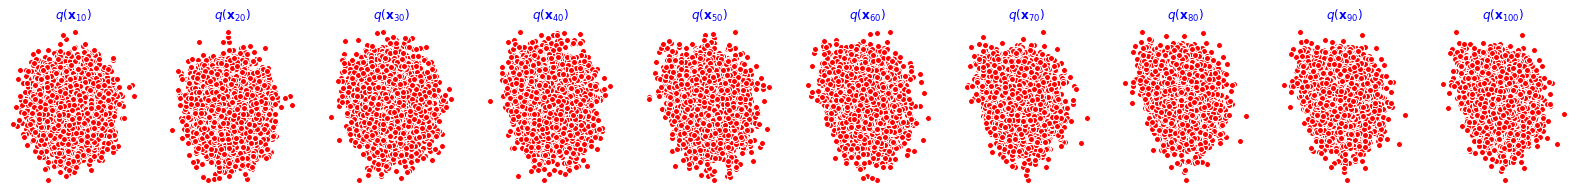

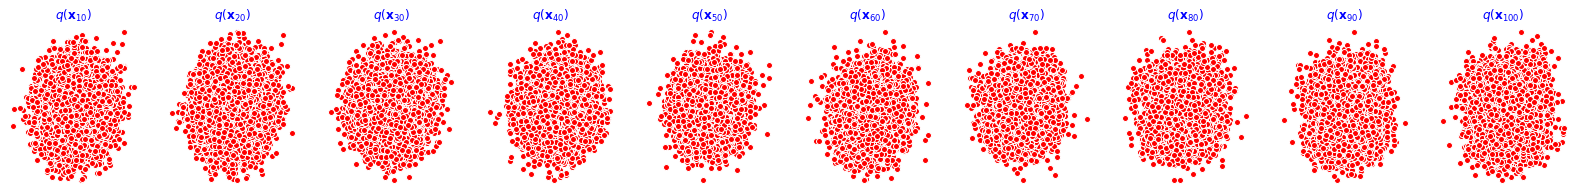

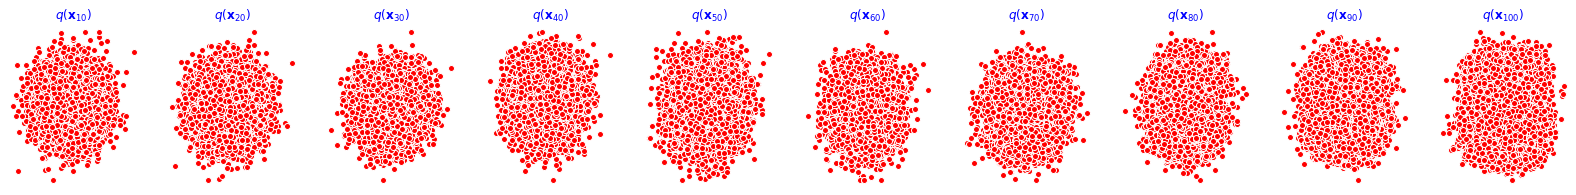

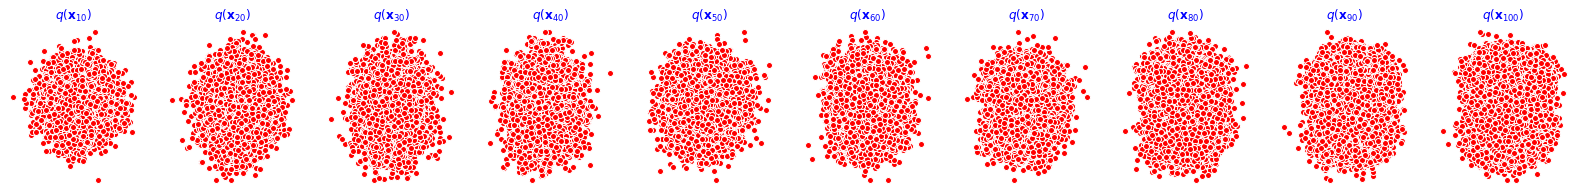

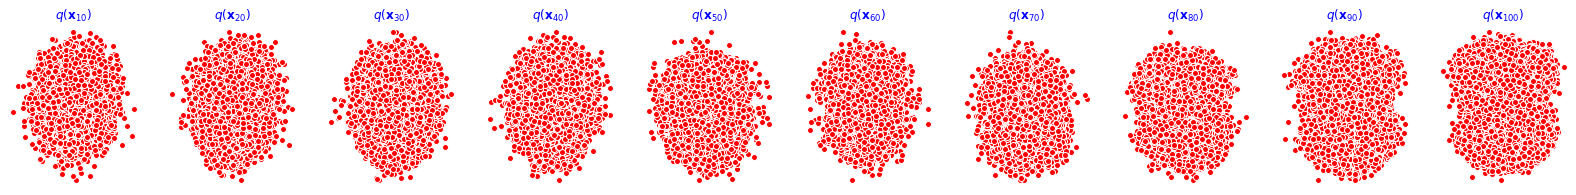

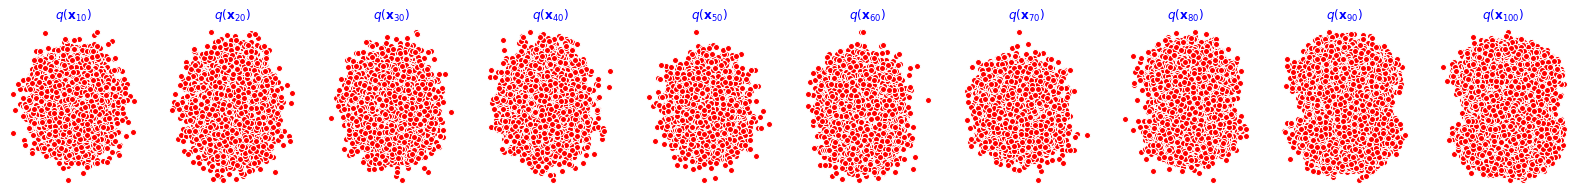

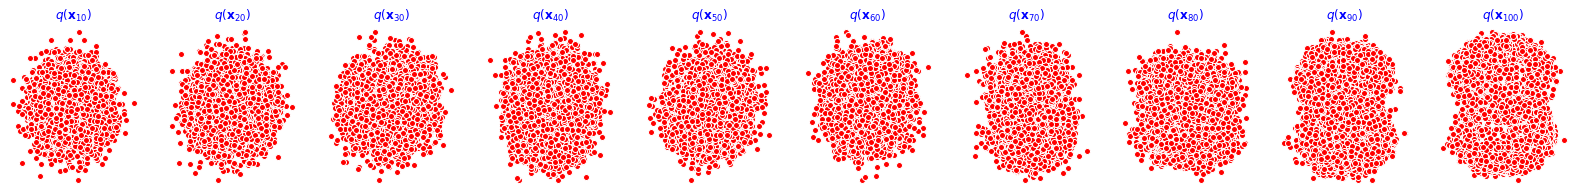

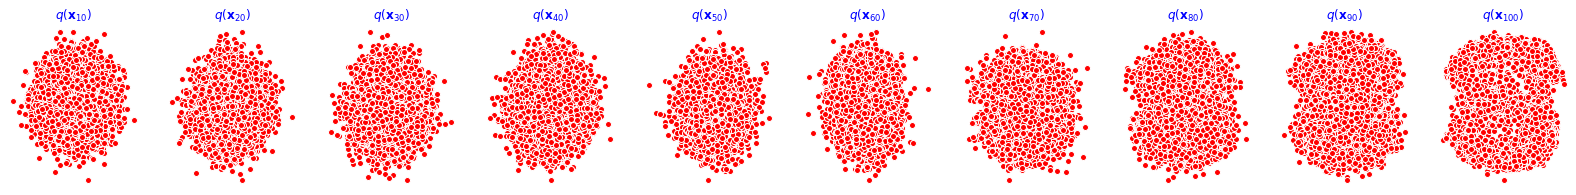

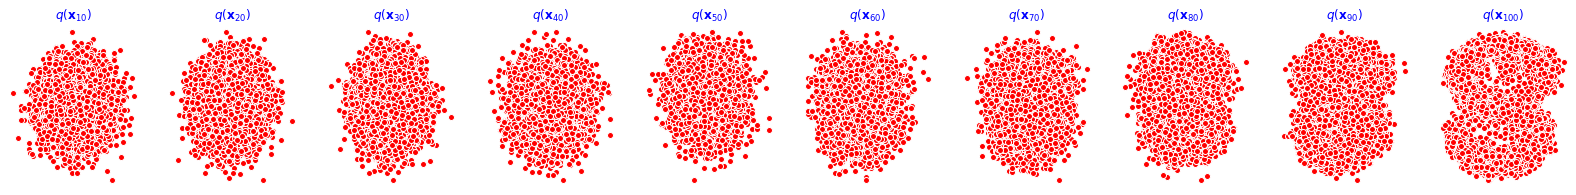

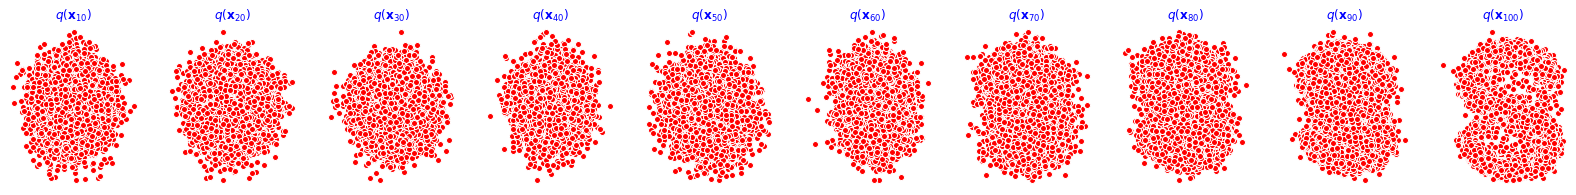

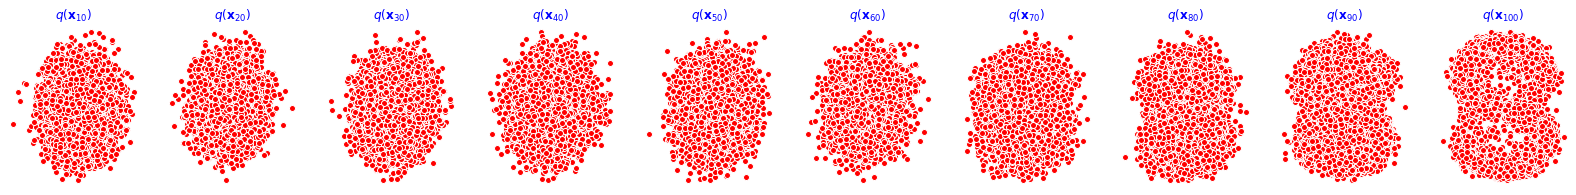

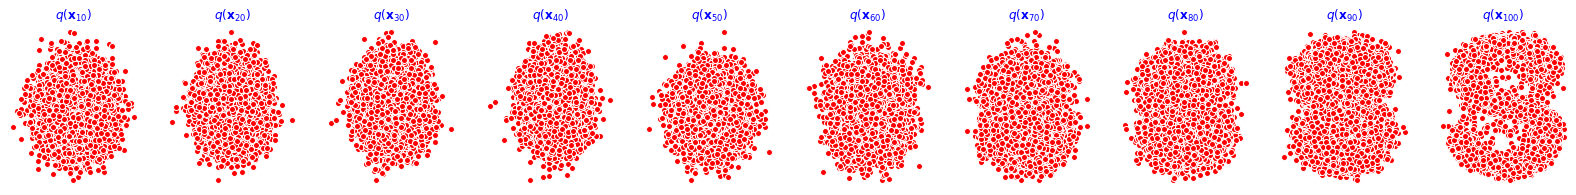

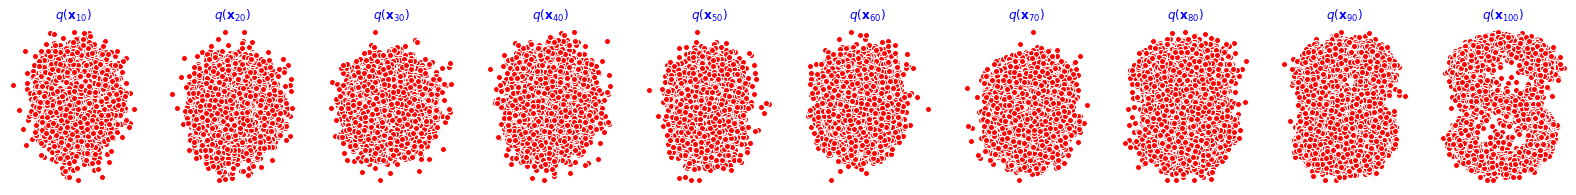

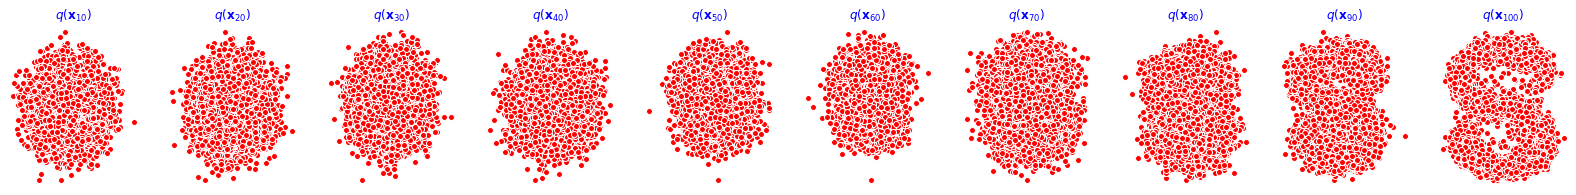

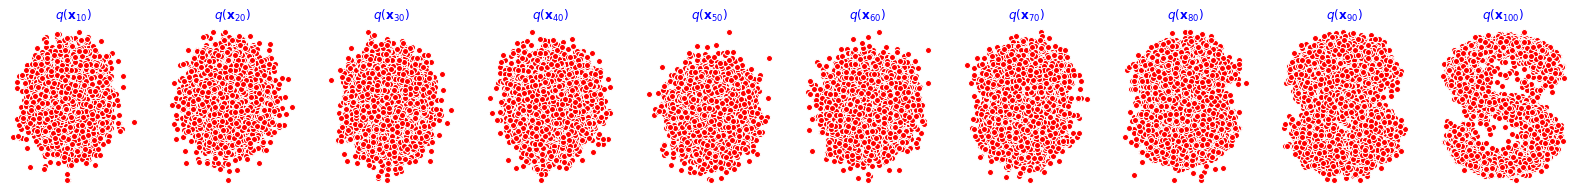

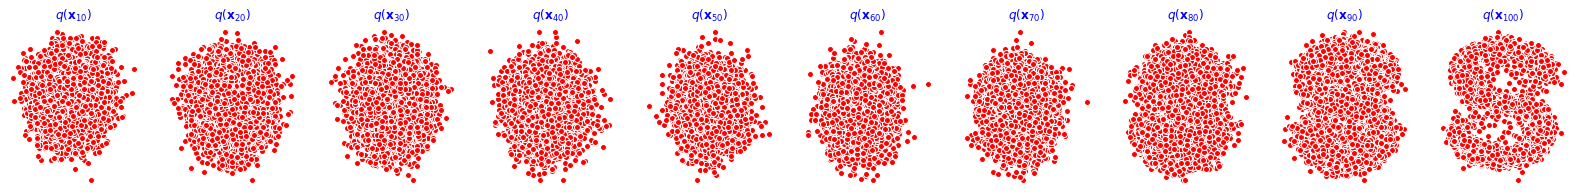

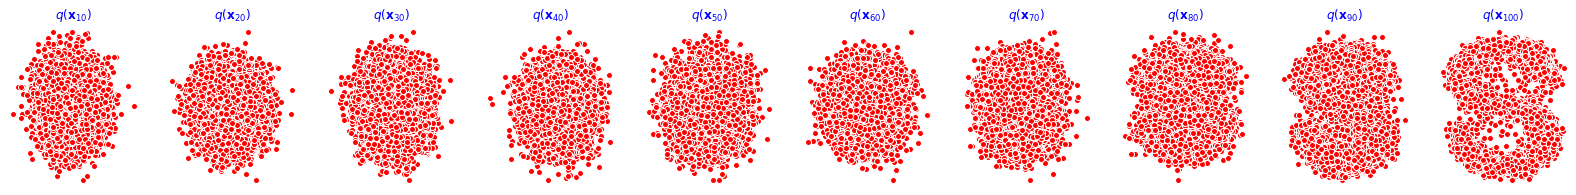

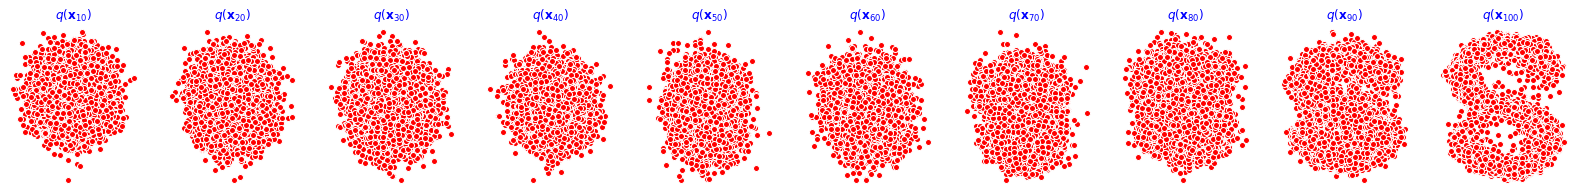

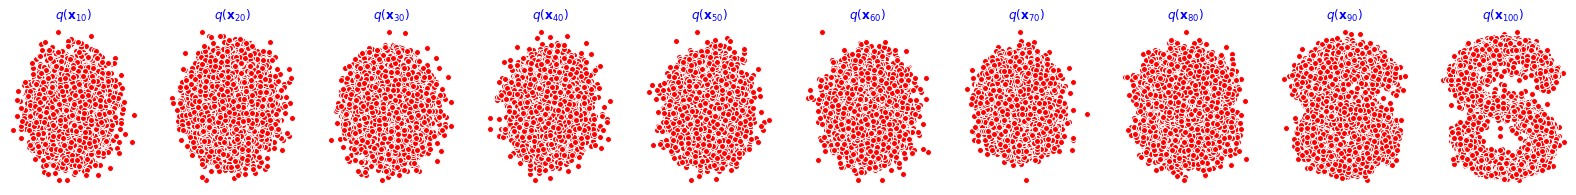

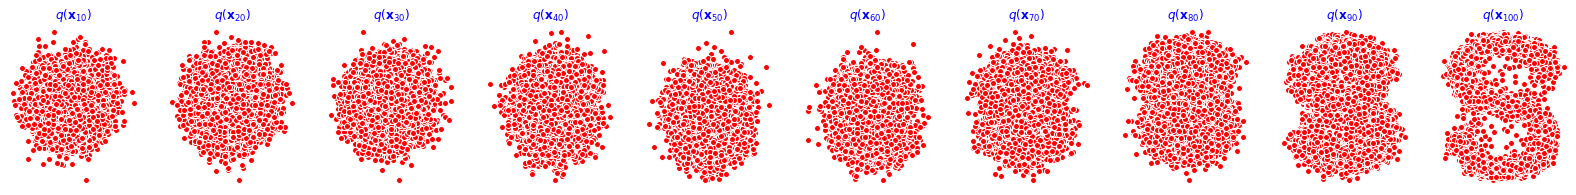

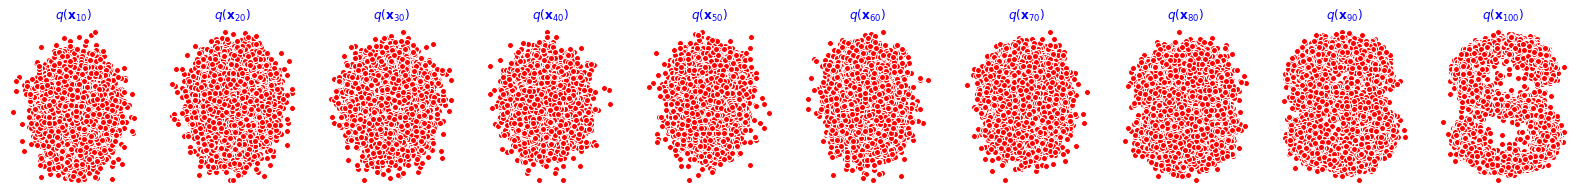

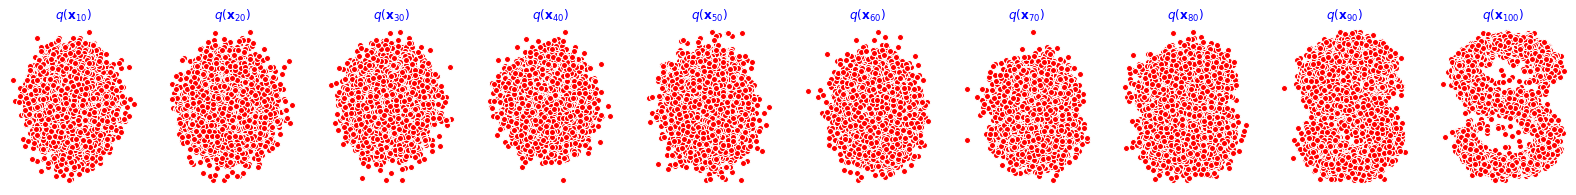

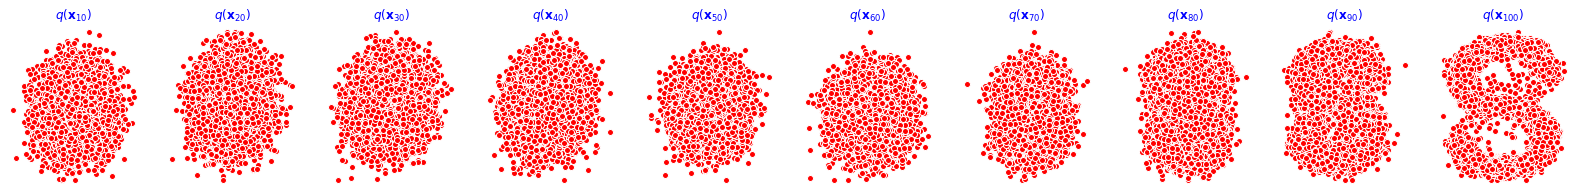

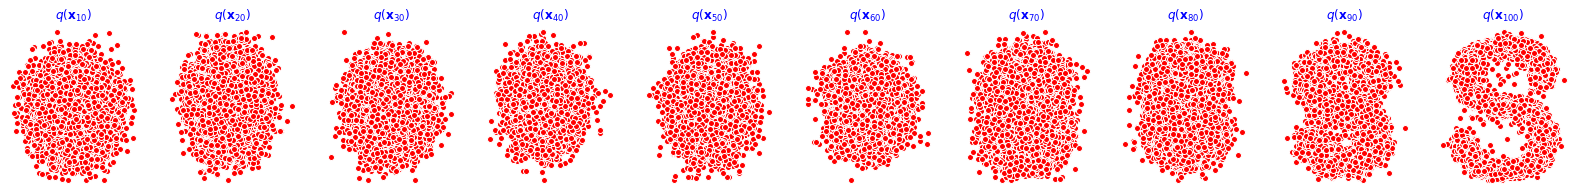

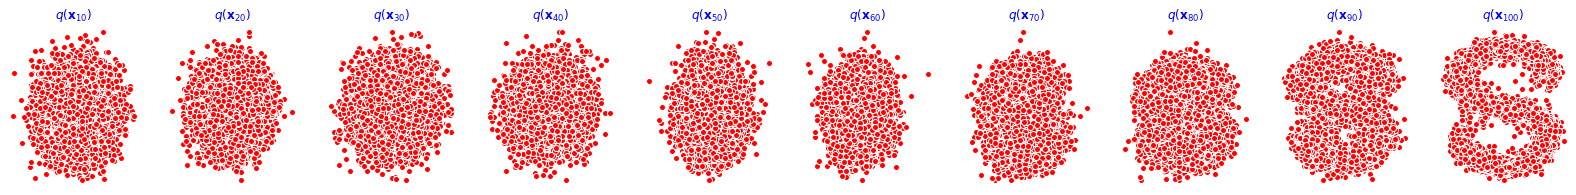

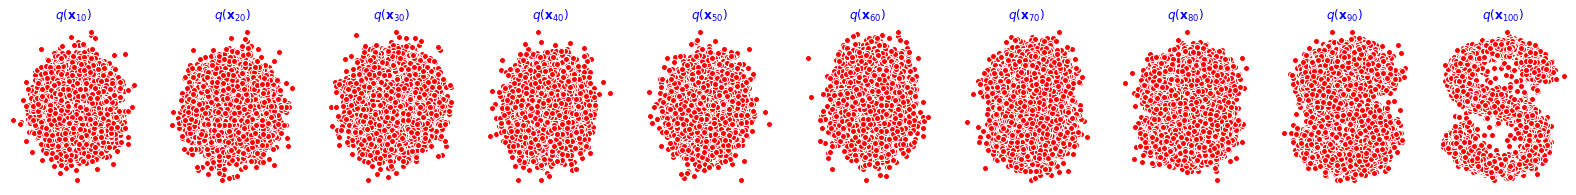

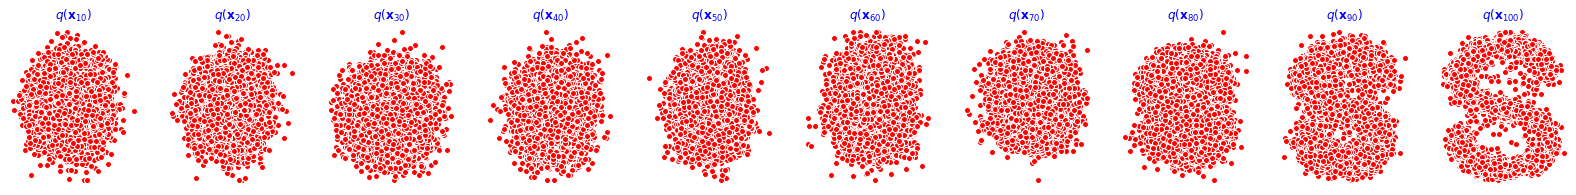

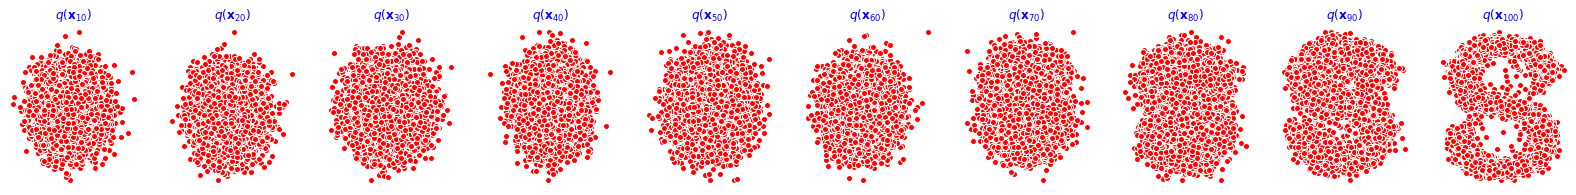

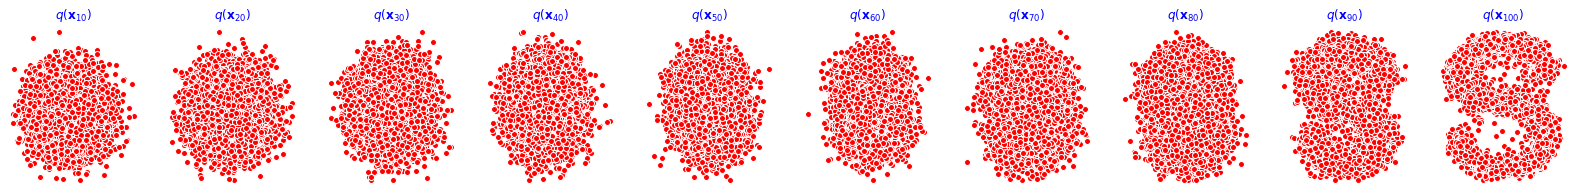

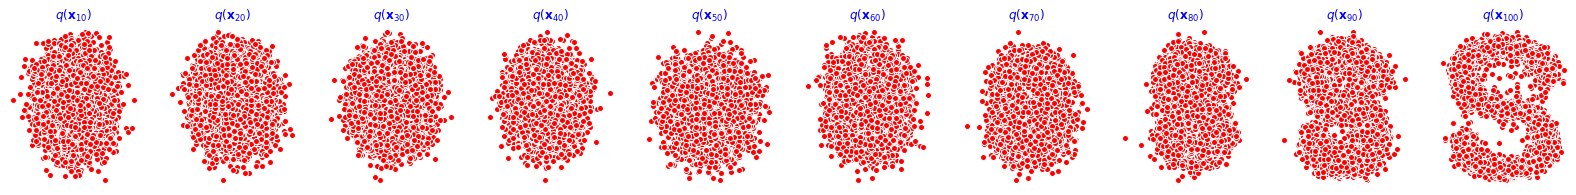

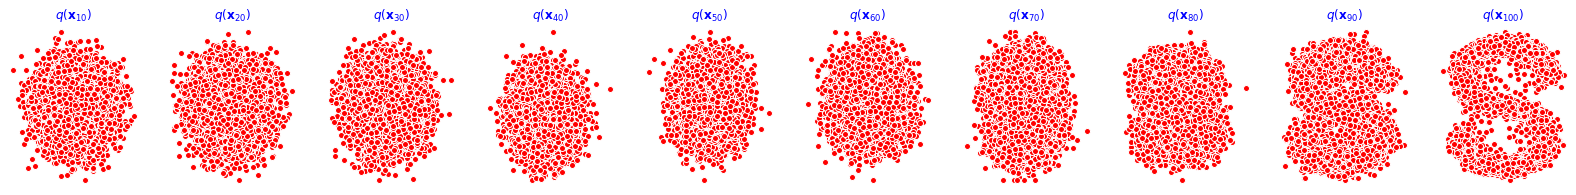

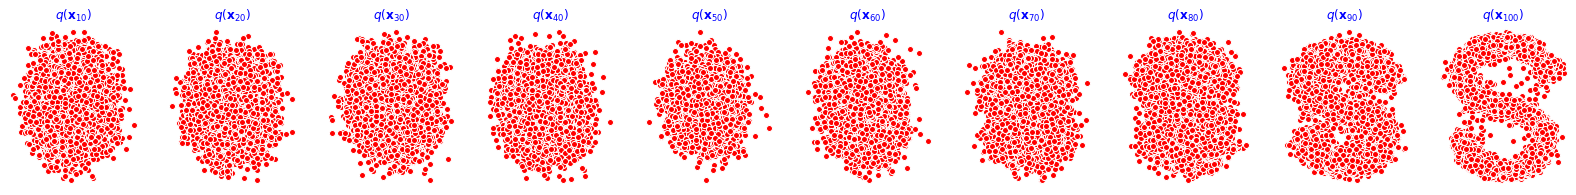

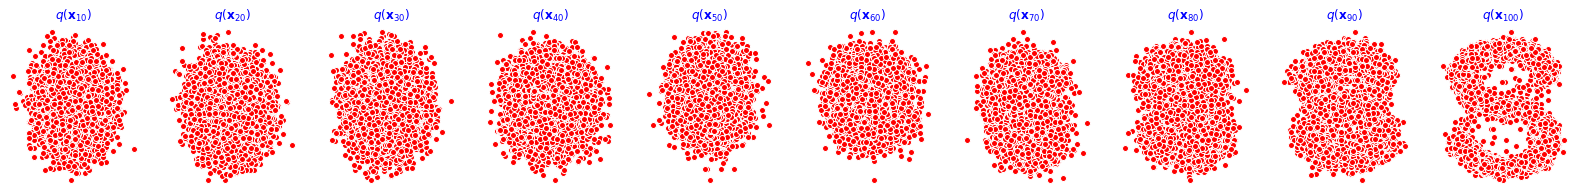

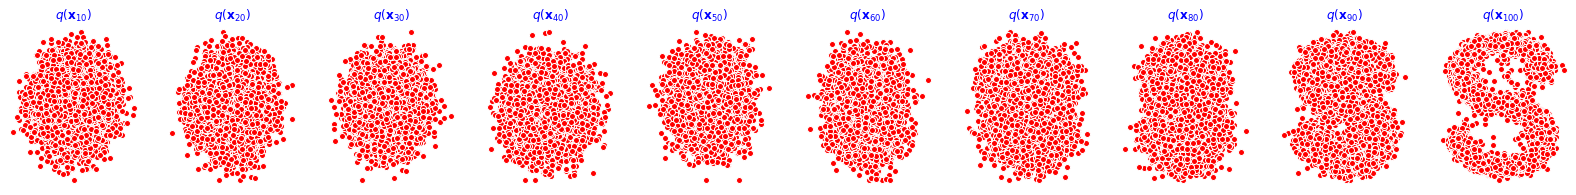

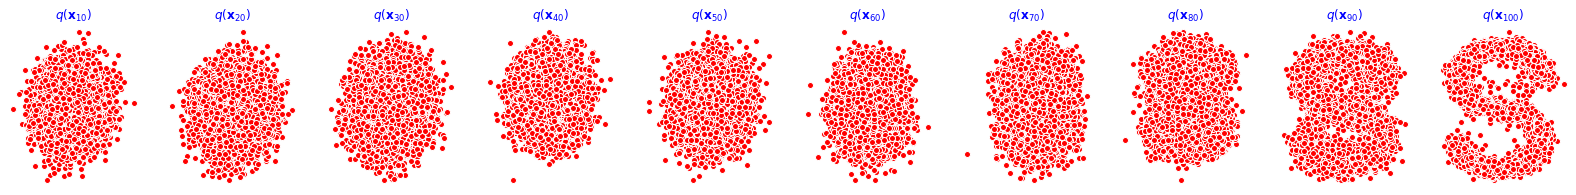

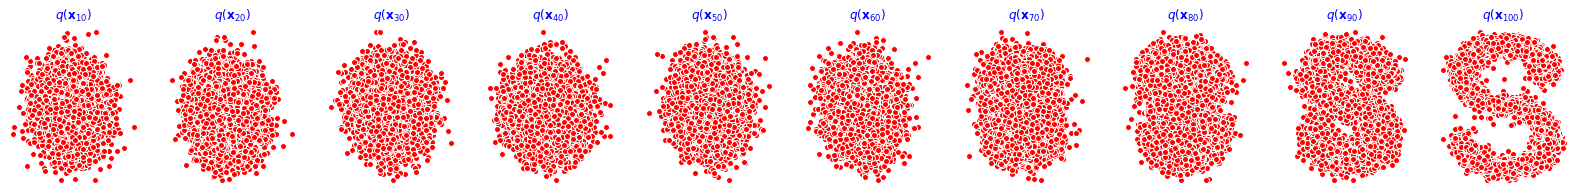

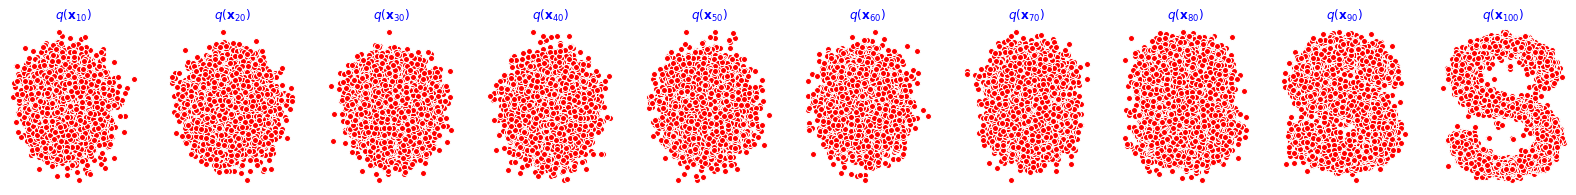

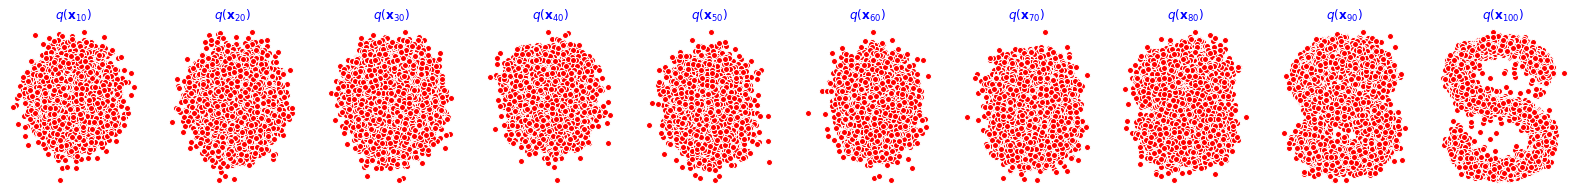

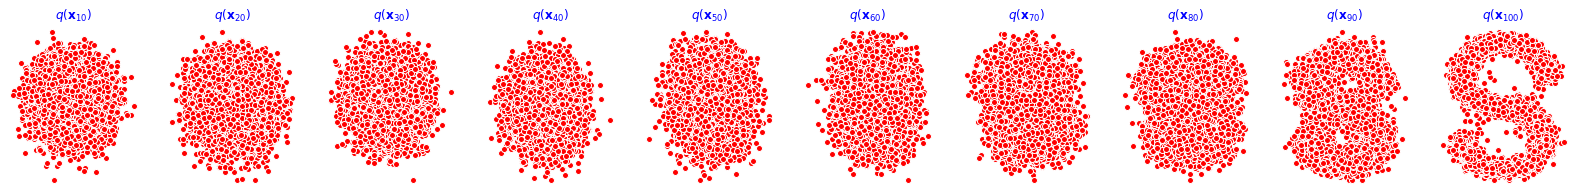

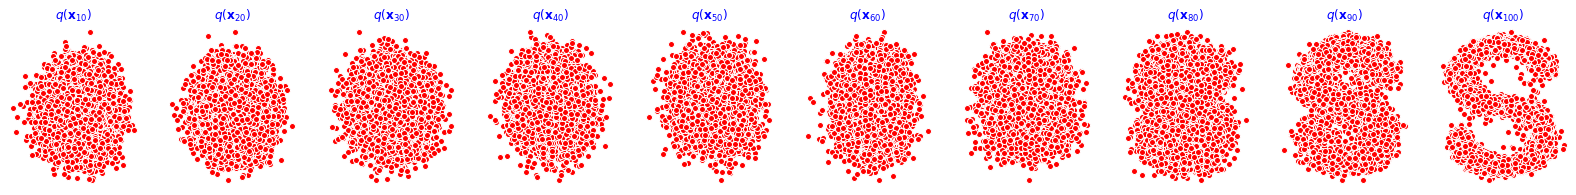

In [122]:
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text', color='blue')

model = MLPDiffusion(num_steps) #输出维度是2， 输入时x和step
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        #print(batch_x.shape) #torch.Size([128, 2])
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.) #梯度裁剪，保持稳定性
        optimizer.step()
    
    #print sample quality and loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt) #共有100个元素
        
        fig, axs = plt.subplots(1, 10, figsize=(28,3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:,0], cur_x[:,1], color='red', edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf{x}_{' + str(i*10)+'})$')

### 动画演示扩散过程和逆扩散过程

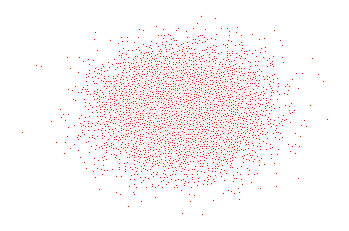

In [125]:
# 生成的前向过程，就是加噪声过程
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf() #当前 figure 的所有axes，但是不关闭这个 window，所以能继续复用于其他的 plot
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:,0], q_i[:,1], color='red', edgecolor='white',s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
    
    

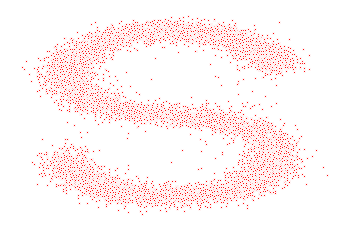

In [128]:
# 逆向去噪
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0], cur_x[:,1], color='red', edgecolor='white', s=5)
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [129]:
imgs = imgs + reverse
imgs[0].save("diffusion.gif", format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)